<a href="https://colab.research.google.com/github/sameepshrestha/segmentation_state_of_the_art/blob/main/best_architecture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Thu Jul  1 11:01:21 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install tensorflow==2.4.1
import tensorflow
print(tensorflow.__version__)

2.4.1


In [ ]:
import matplotlib.pyplot as plt 
import numpy as np 
import cv2 as cv 
from PIL import Image, ImageDraw
import json 
import os 
import glob 
import re 
from tqdm import tqdm
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Conv2D, Reshape, Concatenate,MaxPooling2D, AveragePooling2D,Input, BatchNormalization, Activation, UpSampling2D, Concatenate, LeakyReLU,Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D,Multiply,SpatialDropout2D,Add
from tensorflow.keras.optimizers import Adam, SGD
#using tensorflow backend 16 so keras backend still 32bytes so no keras to be used
# from keras.layers.merge import concatenate,Concatenate
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.resnet import ResNet50
import gc
import psutil

In [ ]:
# model.summary()
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def Augmentation(images,mask):
    def _transform(image,mask):
        transform=A.Compose([
         A.HorizontalFlip(p=0.5),
         A.Rotate([-20,20],p=.25),
    ])
        aug=transform(image=image,mask=mask)
        img=aug['image']
        img=tf.cast(img,tf.float32)
        msk=aug['mask']
        msk=tf.cast(msk,tf.float32)
        return img,msk
    image,mask=tf.numpy_function(_transform,[images,mask],[tf.float32,tf.float32])
    image.set_shape([IMAGE_SIZE, IMAGE_SIZE, 3])
    mask.set_shape([IMAGE_SIZE, IMAGE_SIZE, 38])
    
    return image,mask
AUTO = tf.data.experimental.AUTOTUNE
Image_width = 640 
Image_height = 480 
no_classes =38
def load_data(path, split=0.2):
    images = sorted(glob.glob(os.path.join(path, "image/*")))
    print(len(images))
    masks = sorted(glob.glob(os.path.join(path, "mask2/*")))
    print(len(masks))
    total_size = 7990
    test_size = 1705
    valid_size=1000
    training_x, test_x = train_test_split(images[:7990], test_size=test_size, random_state=42)
    training_y, test_y = train_test_split(masks[:7990], test_size=test_size, random_state=42)
    train_x, valid_x = train_test_split(training_x, test_size=valid_size, random_state=50)
    train_y, valid_y = train_test_split(training_y, test_size=valid_size, random_state=50)
    return (train_x, train_y), (valid_x, valid_y),(test_x, test_y)
(train_x,train_y),(valid_x,valid_y),(test_x, test_y)=load_data('/content/drive/MyDrive/depth')
train_size=len(train_x)
valid_size=len(valid_x)

def read_image(path):
    path = path.decode()
    x = cv.imread(path, cv.IMREAD_COLOR)
    x = cv.resize(x,(640,480),interpolation=cv.INTER_AREA)
    x = x/255.0
    x=tf.cast(x,dtype=tf.float32)
    return x

def read_mask(path):
    path = path.decode()
    x = cv.imread(path, cv.IMREAD_GRAYSCALE)
    x = cv.resize(x,(640,480),interpolation=cv.INTER_NEAREST)
  
    x = to_categorical(x,num_classes=no_classes)
    x = x[:,:,:]
    x=tf.cast(x,dtype=tf.float32)
    return x
# read_mask('/content/drive/MyDrive/depth/mask100/mask1.png')
def parser(x,y):
    def _parse(x,y):
        x=read_image(x)
        y=read_mask(y)
        return x,y
    x,y = tf.numpy_function(_parse, [x,y], [tf.float32,tf.float32])
    x.set_shape([Image_height, Image_width, 3])
    y.set_shape([Image_height, Image_width, no_classes])
    return x,y
    
def tf_dataset(x, y, batch):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.map(parser)

    dataset = dataset.repeat()
    dataset = dataset.shuffle(128, seed =0)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(AUTO)
    return dataset
train_dataset=tf_dataset(train_x,train_y,batch=4)
valid_dataset=tf_dataset(valid_x,valid_y,batch=4)
valid_dataset

8033
8033


<PrefetchDataset shapes: ((None, 480, 640, 3), (None, 480, 640, 38)), types: (tf.float32, tf.float32)>

In [ ]:
def encoder(inputs):
    skip_layers = []
    model2 = ResNet50(include_top=False,weights='imagenet',input_tensor=inputs)
    x = model2.get_layer('conv5_block3_out').output
    # names = ['conv1_bn','conv2_block3_add','conv3_block4_add','conv4_block6_add']
    # for name in names:
    #     layer = model2.get_layer(name).output
    #     print(layer.shape)
    #     skip_layers.append(layer)
    return x
def transistion_conv(x,filter=1024):
    x = Conv2D(filter,(1,1), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = UpSampling2D((2,2))(x)
    return x
def decoder_conv(x,filters = 64):
    print(x.shape)
    y = Conv2D(filters,(3,3), padding="same")(x)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = Conv2D(filters,(3,3), padding="same")(y)
    y = BatchNormalization()(y)
    y = Add()([x,y])
    y = Activation('relu')(y)
    return y
def decoder(x):
    filters  = [1024,512,256,64,64]
    for i in range(len(filters)-1):
        x = decoder_conv(x,filters[i])
        x = decoder_conv(x,filters[i])
        x = transistion_conv(x,filters[i+1])
    return x
def outputs(input):
    x = Conv2D(64,(3,3), padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(38,(1,1), padding="same")(x)
    return x 
def main_model(shape):
    inputs = Input(shape)
    encoded = encoder(inputs)
    transistioned = transistion_conv(encoded) 
    decoded = decoder(transistioned)
    output = outputs(decoded)
    model = Model(inputs,output)
    return model 
shape = (480,640,3)
model = main_model(shape)


94773248/94765736 [==============================] - 1s 0us/step
(None, 30, 40, 1024)
(None, 30, 40, 1024)
(None, 60, 80, 512)
(None, 60, 80, 512)
(None, 120, 160, 256)
(None, 120, 160, 256)
(None, 240, 320, 64)
(None, 240, 320, 64)


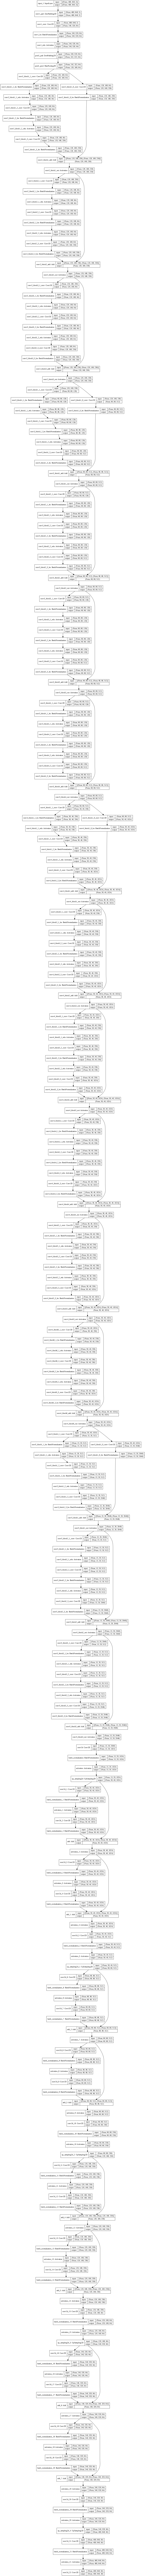

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=64)
# model.summary()

In [ ]:
#loss function 
import gc 
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import CSVLogger ,LearningRateScheduler,Callback
class CustomLearningRateScheduler(tf.keras.callbacks.Callback):
    def __init__(self, schedule):
        super(CustomLearningRateScheduler, self).__init__()
        self.schedule = schedule
    def on_train_batch_end(self, batch, logs=None):
        if not hasattr(self.model.optimizer, "lr"):
            raise ValueError('Optimizer must have a "lr" attribute.')
        lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
        scheduled_lr = self.schedule(batch, lr)
        tf.keras.backend.set_value(self.model.optimizer.lr, scheduled_lr)
        print("\nbatch %05d: Learning rate is %8f." % (batch, scheduled_lr))
def lr_scheduler(batch,lr):
      t_steps = train_size//4
      
    #   if (i+13+12+6)> 30:
    #     lr =0.00000025347102
    #     return lr
      batch = (i+3)*t_steps+batch
      lr = .001 *((1- (batch/(t_steps*40)))**.9)
      return lr
def lr_schedule(i):
      t_steps = train_size//4
      batch = (i+3)*t_steps+1
      lr = .001 *((1- (batch/(t_steps*40)))**.9)
      return lr
def binary_loss(y_true, y_pred):
    loss = binary_crossentropy(y_true, y_pred,from_logits=True)
    loss_value = tf.math.reduce_mean(loss,axis=[0])
    return loss_value

def cross_entropy_loss(y_true,y_pred):
    loss = tf.nn.softmax_cross_entropy_with_logits(
    y_true, y_pred, axis=-1, name=None)
    return loss

def custom_metrics(y_true,y_pred,smooth=1):
    y_pred = tf.math.argmax(y_pred, axis=-1)
    # y_pred = tf.expand_dims(y_pred,axis=-1)
    y_pred = tf.one_hot(y_pred,38)
    y_true = y_true[:,:,:,1:38]
    y_pred= y_pred[:,:,:,1:38]
    intersection  = tf.math.reduce_sum((y_true*y_pred),axis = [1,2,3])
    union = (tf.math.reduce_sum(y_true,axis=[1,2,3])+tf.math.reduce_sum(y_pred,axis = [1,2,3])) - intersection
    return tf.math.reduce_mean((intersection+smooth)/(union+smooth),axis=0)
metrics = tf.keras.metrics.MeanIoU(
    37
)
def custom_metrics2(y_true,y_pred):
    y_pred = tf.math.argmax(y_pred, axis=-1)
    y_pred = tf.one_hot(y_pred,38)
    y_pred = tf.reshape(y_pred,[-1,38])
    y_true = tf.reshape(y_true,[-1,38])
    return metrics(y_true,y_pred)

smooth = 1
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)
model=tf.keras.models.load_model( '/content/drive/MyDrive/new_architecture/best-architecture-june38/Resnet50withoutchanges/all/',custom_objects={
        'cross_entropy_loss': cross_entropy_loss,'custom_metrics':custom_metrics })

In [ ]:
lr =.001
# model.compile(loss = cross_entropy_loss,optimizer = Adam(learning_rate =lr,beta_1= 0.9),metrics = [custom_metrics])
epoch=24
t_steps = train_size//4
v_steps=valid_size//4
val_custom_metrics = 0.41
val_metrics =[]
for i in range(epoch):
  print('epoch =',i+1)
  lr = lr_schedule(i)
  model.compile(loss = cross_entropy_loss,optimizer=SGD(learning_rate =lr,momentum= 0.9),metrics=[custom_metrics])
  model.fit(train_dataset,epochs= 1,steps_per_epoch=t_steps,callbacks=[CustomLearningRateScheduler(lr_scheduler)])
#   model.fit(train_dataset,epochs= 1,steps_per_epoch=t_steps,callbacks=[CustomLearningRateScheduler(lr_scheduler)])
  loss = model.evaluate(valid_dataset,steps=v_steps)
  model.save('/content/drive/MyDrive/new_architecture/best-architecture-june38/Resnet50withoutchanges/all/',save_format='tf')
  if loss[1]>=val_custom_metrics:
    val_custom_metrics = loss[1]
    model.save('/content/drive/MyDrive/new_architecture/best-architecture-june38/Resnet50withoutchanges/best/',save_format='tf')
  tf.keras.backend.clear_session()
  gc.collect()

Streaming output truncated to the last 5000 lines.
  24/1321 [..............................] - ETA: 27:40 - loss: 0.7545 - custom_metrics: 0.6446
batch 00023: Learning rate is 0.000678.
  25/1321 [..............................] - ETA: 27:37 - loss: 0.7544 - custom_metrics: 0.6441
batch 00024: Learning rate is 0.000678.
  26/1321 [..............................] - ETA: 27:37 - loss: 0.7546 - custom_metrics: 0.6433
batch 00025: Learning rate is 0.000678.
  27/1321 [..............................] - ETA: 27:36 - loss: 0.7548 - custom_metrics: 0.6429
batch 00026: Learning rate is 0.000678.
  28/1321 [..............................] - ETA: 27:36 - loss: 0.7545 - custom_metrics: 0.6426
batch 00027: Learning rate is 0.000678.
  29/1321 [..............................] - ETA: 27:35 - loss: 0.7541 - custom_metrics: 0.6425
batch 00028: Learning rate is 0.000678.
  30/1321 [..............................] - ETA: 27:34 - loss: 0.7539 - custom_metrics: 0.6423
batch 00029: Learning rate is 0.00067